Sentences shape: (44758, 3)
Labels shape: (44758, 40)
Merged ValuesML shape: (44758, 41)
ValuesML long format shape: (28113, 3)

ValuesML frequencies:
                schwartz_value     polarity  count
15                    Humility  constrained     33
14                    Humility     attained     77
13                    Hedonism  constrained    122
31                   Tradition  constrained    123
27     Self-direction: thought  constrained    132
3          Benevolence: caring  constrained    179
29                 Stimulation  constrained    201
5   Benevolence: dependability  constrained    219
36     Universalism: tolerance     attained    241
37     Universalism: tolerance  constrained    262
12                    Hedonism     attained    279
6    Conformity: interpersonal     attained    285
35        Universalism: nature  constrained    295
20          Security: personal     attained    347
7    Conformity: interpersonal  constrained    354
25      Self-direction: action  c

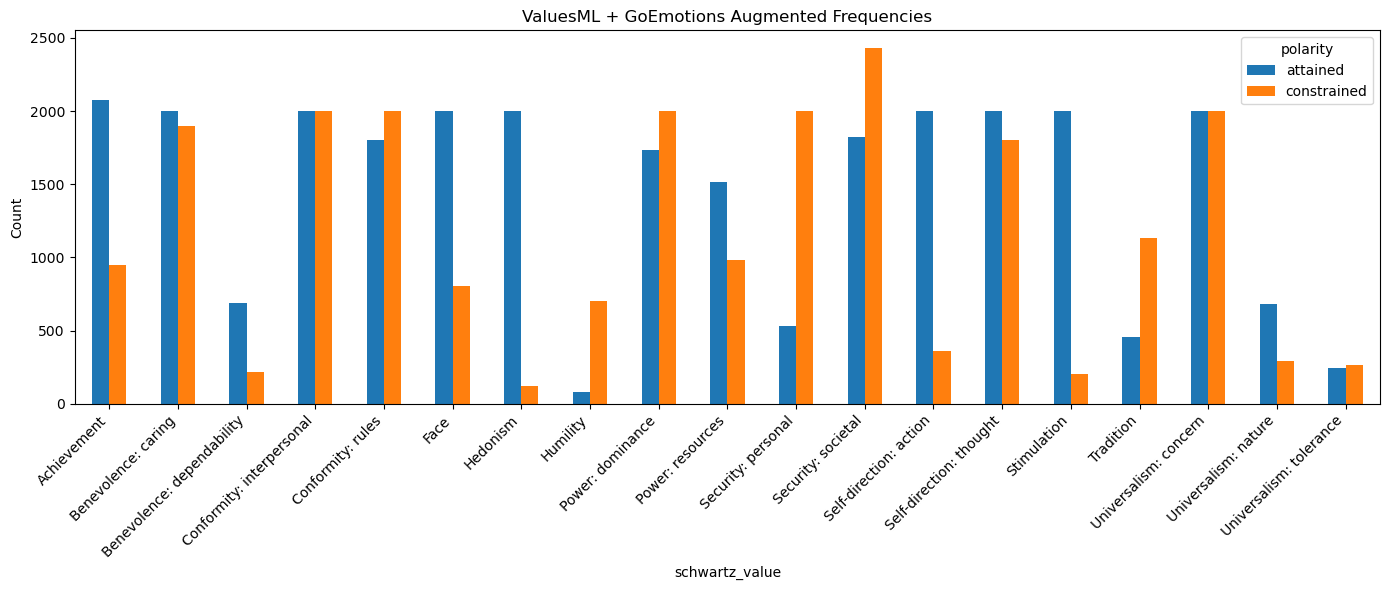


Saved augmented dataset to training-english/training_augmented.tsv


<Figure size 640x480 with 0 Axes>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import collections


sent_file = "training-english/sentences_training.tsv"
label_file = "training-english/labels_training.tsv"

sent_df = pd.read_csv(sent_file, sep="\t")
label_df = pd.read_csv(label_file, sep="\t")

print("Sentences shape:", sent_df.shape)
print("Labels shape:", label_df.shape)


valuesml_df = pd.merge(sent_df, label_df, on=["Text-ID", "Sentence-ID"])
print("Merged ValuesML shape:", valuesml_df.shape)

long_rows = []
for _, row in valuesml_df.iterrows():
    text = row["Text"]
    for col in label_df.columns[2:]:  # skip Text-ID, Sentence-ID
        if "attained" in col or "constrained" in col:
            value_name = col.replace(" attained", "").replace(" constrained", "")
            polarity = "attained" if "attained" in col else "constrained"
            val = row[col]
            if val > 0:  # 1 or 0.5 (partial)
                long_rows.append({
                    "Text": text,
                    "schwartz_value": value_name,
                    "polarity": polarity
                })

valuesml_long = pd.DataFrame(long_rows)
print("ValuesML long format shape:", valuesml_long.shape)

val_counts = valuesml_long.groupby(["schwartz_value", "polarity"]).size().reset_index(name="count")
print("\nValuesML frequencies:")
print(val_counts.sort_values("count"))

dataset = load_dataset("go_emotions")
df = pd.concat([
    dataset["train"].to_pandas(),
    dataset["validation"].to_pandas(),
    dataset["test"].to_pandas()
], ignore_index=True)
print("\nGoEmotions shape:", df.shape)

goemo_label_names = dataset["train"].features["labels"].feature.names

goemo_to_schwartz_polarity = {
    "admiration":     (["Achievement", "Face"], "attained"),
    "amusement":      (["Hedonism", "Stimulation"], "attained"),
    "anger":          (["Power: dominance"], "constrained"),
    "annoyance":      (["Conformity: rules", "Conformity: interpersonal"], "constrained"),
    "approval":       (["Conformity: interpersonal", "Face"], "attained"),
    "caring":         (["Benevolence: caring"], "attained"),
    "confusion":      (["Self-direction: thought"], "constrained"),
    "curiosity":      (["Self-direction: thought", "Stimulation"], "attained"),
    "desire":         (["Stimulation", "Achievement"], "attained"),
    "disappointment": (["Security: personal"], "constrained"),
    "disapproval":    (["Conformity: rules", "Conformity: interpersonal"], "constrained"),
    "disgust":        (["Tradition", "Conformity: rules"], "constrained"),
    "embarrassment":  (["Face", "Conformity: interpersonal"], "constrained"),
    "excitement":     (["Stimulation", "Hedonism"], "attained"),
    "fear":           (["Security: personal"], "constrained"),
    "gratitude":      (["Benevolence: caring"], "attained"),
    "grief":          (["Benevolence: caring", "Universalism: concern"], "constrained"),
    "joy":            (["Hedonism"], "attained"),
    "love":           (["Benevolence: caring", "Universalism: concern"], "attained"),
    "nervousness":    (["Security: personal"], "constrained"),
    "optimism":       (["Achievement", "Self-direction: action"], "attained"),
    "pride":          (["Achievement", "Face"], "attained"),
    "relief":         (["Security: personal"], "attained"),
    "remorse":        (["Conformity: interpersonal", "Humility"], "constrained"),
    "sadness":        (["Benevolence: caring", "Universalism: concern"], "constrained"),
    "surprise":       (["Stimulation"], "attained"),
    "neutral":        ([], None)
}

rows = []
for text, label_list in zip(df["text"], df["labels"]):
    if isinstance(label_list, (np.ndarray, pd.Series)):
        label_list = label_list.tolist()
    for lid in label_list:
        emo = goemo_label_names[lid]
        vals, polarity = goemo_to_schwartz_polarity.get(emo, ([], None))
        if not vals or polarity is None:
            continue
        for v in vals:
            rows.append({"Text": text, "schwartz_value": v, "polarity": polarity})

goemo_df = pd.DataFrame(rows)
print("Mapped GoEmotions shape:", goemo_df.shape)


THRESHOLD = 2000  
low_freq_pairs = val_counts[val_counts["count"] < THRESHOLD][["schwartz_value", "polarity"]].values.tolist()
print("\nLow-frequency pairs needing augmentation:", low_freq_pairs)

augment_dfs = []
for v, p in low_freq_pairs:
    candidates = goemo_df[(goemo_df["schwartz_value"] == v) & (goemo_df["polarity"] == p)]
    if not candidates.empty:
        current_count = val_counts[(val_counts["schwartz_value"]==v) & (val_counts["polarity"]==p)]["count"].values[0]
        needed = THRESHOLD - current_count
        augment_dfs.append(candidates.sample(n=min(len(candidates), needed), random_state=42))

augment_df = pd.concat(augment_dfs, ignore_index=True) if augment_dfs else pd.DataFrame(columns=["Text","schwartz_value","polarity"])
print("\nAugmented samples:", augment_df.shape)

augmented_train = pd.concat([valuesml_long, augment_df], ignore_index=True)
print("Augmented training shape:", augmented_train.shape)


before_counts = val_counts.set_index(["schwartz_value","polarity"])["count"]
after_counts = augmented_train.groupby(["schwartz_value","polarity"]).size()

freq_compare = pd.DataFrame({"before": before_counts, "after": after_counts}).fillna(0).astype(int)
print("\nFrequency comparison (before vs after):")
print(freq_compare)


pivot = freq_compare.reset_index().pivot(index="schwartz_value", columns="polarity", values="after").fillna(0)
pivot.plot(kind="bar", figsize=(14,6))
plt.title("ValuesML + GoEmotions Augmented Frequencies")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


augmented_train.to_csv("training-english/training_augmented.tsv", sep="\t", index=False)
plt.savefig("training-english/value_distribution_after_augmentation.pdf", bbox_inches="tight")

print("\nSaved augmented dataset to training-english/training_augmented.tsv")


In [2]:
target = 1500
underrepresented = freq_compare[freq_compare["after"] < target]
print(underrepresented)


                                        before  after
schwartz_value             polarity                  
Achievement                constrained     950    950
Benevolence: dependability attained        689    689
                           constrained     219    219
Face                       constrained     432    807
Hedonism                   constrained     122    122
Humility                   attained         77     77
                           constrained      33    702
Power: resources           constrained     985    985
Security: personal         attained        347    529
Self-direction: action     constrained     361    361
Stimulation                constrained     201    201
Tradition                  attained        454    454
                           constrained     123   1136
Universalism: nature       attained        680    680
                           constrained     295    295
Universalism: tolerance    attained        241    241
                           c

In [ ]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM



tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.3-13B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.3-13B-Instruct")
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


def generate_sentences_llama(value, polarity, n=20, max_length=200):
    prompt = f"Generate {n} English sentences (15–25 words each) that express the human value '{value}' being {polarity}. " \
             "Each sentence should be realistic, diverse, and not repetitive. One sentence per line."
    

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    

    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        temperature=0.9,
        num_return_sequences=n
    )
    

    sentences = [tokenizer.decode(output, skip_special_tokens=True).strip() for output in outputs]
    result = []
    for s in sentences:
        result.extend([line.strip() for line in s.split("\n") if line.strip()])
    
    return result[:n] 


generated = []
while len(generated) < 550:
    batch = generate_sentences_llama("Achievement", "constrained", n=20)
    generated.extend(batch)


generated = generated[:550]


for i, sentence in enumerate(generated[:10]):
    print(f"{i+1}: {sentence}")
